## Names

- Coin Gecko API call (already done)
- Select the top 1000 for marketcap

In [286]:
# Gets the ids and symbols for each coin listed on coingecko

import requests
import json
response = requests.get("https://api.coingecko.com/api/v3/coins/list")
if response.status_code == 200:
    data = response.json()
else:
    print("Request was not a success")
import pandas as pd
df = pd.DataFrame(data, columns=data[0].keys())

In [287]:
df.to_csv('./NamesFromCoinGecko.csv',index = False)

### Experimenting with locating elements in a Pandas Dataframe

In [185]:
%timeit df.loc[0,['id']]

535 µs ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
%timeit df['id'][0]

4.81 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [262]:
df.loc[:3,:]

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0vix-protocol,vix,0VIX Protocol
3,0x,zrx,0x Protocol


## Get Market Cap by using the Gecko API

Split the ids of the coin into batches since there is a batch limit when using the Gecko API

In [296]:
import numpy as np
batches = [','.join(df.id[e:np.min([e+100,len(df.id)])]) for e in range(0,len(df.id) - len(df.id)%100+100,100)]

Note that the API returns data in an unstructured way. So cannot iterate incrementally through both the current and received list of ids. We need to manually match these.

Update:
I realised we could have created a dataframe from the response and then merged the final dataframes by column 'symbol'.

Need to run this on a while loop and use raspberry pi. This will take approximately 1 day to collect the required data

In [298]:
from urllib.parse import quote
ids_ = quote(batches[0]) #Converts string to normal url code i.e. , replace by %C

cross_reference_check_Name = df.name

#Uncomment these lines if running for the first time
# new_df_rows = [] # Stores culmination of rows of each api call
# k=0  #k is used to index the reference df.

#Introduce batch numbers since the free api limits requests of 10-30 per 30 minutes depending on traffic.
#Get around is to activate vpn in a different country every time the rate limit has been exceeded.
batch_num =0
for batch in batches:
    if batch_num<3:
        batch_num +=1
        continue

    #The response outputs a list of dictionaries
    response = requests.get("https://api.coingecko.com/api/v3/coins/markets?vs_currency=gbp&ids=" + batch+"&order=market_cap_desc&per_page=100&page=1&sparkline=false&locale=en")
    
    if response.status_code == 200:
        print("Conncetion successful")
        data = response.json()
        for i in range(0,100):
            if k+i > len(cross_reference_check_Name): # Check if we have found all the required ids
                break

            #Find dictionary in the response which corresponds with the intial dataset
            dictionary = next((item for item in data if item['name'] ==cross_reference_check_Name[k+i]),None)
            if dictionary == None:
                continue

            #Construct the dataframe by creating a list of rows and adding to this global list
            desired_categories = ['name','market_cap','market_cap_rank','total_supply','max_supply','circulating_supply','image','ath_date','atl_date']
            row = [dictionary.get(key) for key in desired_categories]
            new_df_rows.append(row)
        
        #Update indexing
        k+=100
        batch_num+=1
    else:
        print("Connection unsuccessful on batch: ",batch_num)
        break

Connection unsuccessful on batch:  3


### Create a dataframe where we have the market caps and names symbols etc.

In [300]:
merged_dataframe = pd.merge(df,pd.DataFrame(new_df_rows,columns = desired_categories), on = 'name', how = 'inner')

Checking that there are no duplicates.

Concluded that there are duplicates so need to merge by a different column. that is change to ```name```. (Completed)

In [301]:
len(pd.DataFrame(new_df_rows,columns = desired_categories))
len(df)
len(merged_dataframe.index.values)

300

In [302]:
merged_dataframe

,id,symbol,name,market_cap,market_cap_rank,total_supply,max_supply,circulating_supply,image,ath_date,atl_date
0,01coin,zoc,01coin,0.0,NaN,6.565882e+07,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/5720...,2018-10-10T17:27:38.034Z,2022-07-04T08:03:24.254Z
1,0chain,zcn,Zus,4600333.0,1176.0,4.000000e+08,NaN,4.840098e+07,https://assets.coingecko.com/coins/images/4934...,2021-11-10T12:21:06.184Z,2021-12-14T21:31:35.868Z
2,0vix-protocol,vix,0VIX Protocol,NaN,NaN,NaN,NaN,NaN,https://assets.coingecko.com/coins/images/2908...,None,None
3,0x,zrx,0x Protocol,150704941.0,182.0,1.000000e+09,1.000000e+09,8.474961e+08,https://assets.coingecko.com/coins/images/863/...,2018-07-28T14:41:06.104Z,2020-03-13T02:27:49.563Z
4,0x0-ai-ai-smart-contract,0x0,0x0.ai: AI Smart Contract,41777892.0,412.0,8.912500e+08,1.000000e+09,8.912500e+08,https://assets.coingecko.com/coins/images/2888...,2023-05-21T09:08:13.239Z,2023-02-01T14:29:44.928Z
...,...,...,...,...,...,...,...,...,...,...,...
295,aitravis,tai,AITravis,0.0,NaN,1.000000e+09,1.000000e+09,0.000000e+00,https://assets.coingecko.com/coins/images/2893...,2023-02-04T10:15:08.003Z,2023-03-09T21:05:57.537Z
296,aiwallet,aiwallet,AiWallet,0.0,NaN,1.000000e+09,1.000000e+09,0.000000e+00,https://assets.coingecko.com/coins/images/2911...,2023-02-21T02:34:09.189Z,2023-05-12T08:41:49.345Z
297,aiwork,awo,AiWork,0.0,NaN,1.000000e+10,NaN,0.000000e+00,https://assets.coingecko.com/coins/images/1537...,2022-04-15T15:14:29.912Z,2023-05-13T19:21:31.586Z
298,ajna-protocol,ajna,Ajna Protocol,NaN,NaN,1.000000e+09,1.000000e+09,NaN,https://assets.coingecko.com/coins/images/3018...,None,None


There are duplicated symbols

In [304]:
duplicate_rows = df[df['symbol'].duplicated()]
print(duplicate_rows)

                     id symbol                name
28     1sol-io-wormhole   1sol  1sol.io (Wormhole)
94          aave-bat-v1   abat         Aave BAT v1
96         aave-busd-v1  abusd        Aave BUSD v1
99          aave-dai-v1   adai         Aave DAI v1
101         aave-enj-v1   aenj         Aave ENJ v1
...                 ...    ...                 ...
10194            zoodao    zoo              ZooDAO
10195         zookeeper    zoo           ZooKeeper
10200               zro    zro           Carb0n.fi
10208              zusd   zusd                ZUSD
10211           zynergy    zyn             Zynergy

[1538 rows x 3 columns]


In [254]:
not df['symbol'].duplicated().any()

False

In [305]:
merged_dataframe['market_cap'].describe()

count    2.900000e+02
mean     6.432161e+06
std      4.880251e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.363350e+04
max      7.584793e+08
Name: market_cap, dtype: float64

(array([32.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.03530300e+06, 7.67797062e+07, 1.52524109e+08, 2.28268513e+08,
        3.04012916e+08, 3.79757319e+08, 4.55501722e+08, 5.31246125e+08,
        6.06990529e+08, 6.82734932e+08, 7.58479335e+08]),
 <BarContainer object of 10 artists>)

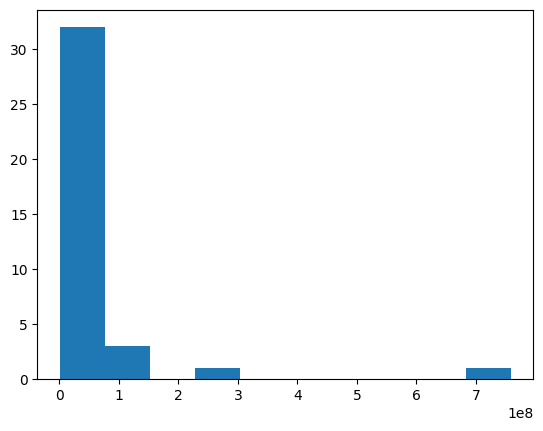

In [306]:
import matplotlib.pyplot as plt
plt.hist(list(merged_dataframe[merged_dataframe['market_cap']>1e6]['market_cap']))

In [312]:
MarketCap_threshold_lower_bound = 1e6
df_ = merged_dataframe[merged_dataframe['market_cap']>MarketCap_threshold_lower_bound]
df_.to_csv('./Coins.csv',index = False)


Need to draw conclusions from this plot

## Whitepapers

Need to locate same whitepaper on both golden and coingecko for validity.

In [315]:
df = pd.read_csv('./Coins.csv')

- Use Golden query tool to obtain the golden wiki page link.
- Use golden database to obtain the whitepapers? Or can we access these through the golen wiki page?

In [338]:
from bs4 import BeautifulSoup
import requests
test_name = 'ACryptoS'

url = 'https://golden.com/search/' +test_name 

response = requests.get(url)
html_content = response.content

soup = BeautifulSoup(html_content, 'html.parser')
all_links = soup.find_all('a')

hyperlinks = [link.get('href') for link in all_links]


for link in hyperlinks:
    contains = False
    if 'wiki/'+test_name in link:
        wiki_url = 'https://golden.com'+link + '/structured_data'
        contains = True
        break
if contains == False:
    print('doesn\'t have a correspondence with golden')


In [355]:
from bs4 import BeautifulSoup
import requests

# make a GET request to the webpage
response = requests.get(wiki_url)


# parse the content with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# find the unnested div containing the word 'Whitepaper'
div_with_whitepaper = soup.find(lambda tag: tag.name == "div" and "Whitepaper" in tag.text and not tag.find('div'))
if div_with_whitepaper == None:
    print('No links to whitepaper')
# find the next div
next_div = div_with_whitepaper.find_next('div')

# find all 'a' tags within this div
a_tags = next_div.find_all('a')

# get the links
whitepaper_links = [a_tag.get('href') for a_tag in a_tags]

# print the links
print('whiepaper_links: \n',whitepaper_links)

# find the unnested div containing the word 'Whitepaper'
div_with_off_website = soup.find(lambda tag: tag.name == "div" and "Official Website" in tag.text and not tag.find('div'))
if div_with_off_website == None:
    print('No official website tag')

# find the next div
next_div = div_with_off_website.find_next('div')

# find all 'a' tags within this div
a_tags = next_div.find_all('a')

# get the links
website_links = [a_tag.get('href') for a_tag in a_tags]

# print the links
print('website_links: \n', website_links)

whiepaper_links: 
 ['https://docs.acryptos.com/']
website_links: 
 ['https://acryptos.com', 'https://app-v2.acryptos.com', 'https://app.acryptos.com', 'https://medium.com/acryptos']


CoinGecko Find the corresponding whitepaper links and url links

- Access page by the 'id' of the row.
- Check if the div contains the links to whitepapers
- Check if the div contains links to the official website

Updates:
- I was getting errors when using Beautifull Soup, presumably as a result of coingecko being resilient against scraping
- Used Selenium instead (Takes longer and more computationally expensive) but may be able to bypass this

In [374]:
from selenium import webdriver
from selenium.webdriver.common.by import By

# Set up the Selenium WebDriver
driver = webdriver.Chrome()  # You'll need to have Chrome WebDriver installed



In [397]:
driver.get('https://www.coingecko.com/en/coins/swaprum')
div_with_website = driver.find_element(By.XPATH,"//span[contains(text(), 'Website')]/ancestor::div[1]")

whitepaper_links = []
website_links = []
html_text = div_with_website.get_attribute('innerHTML')
if 'Website' in div_with_website.text:
    inner_div = div_with_website.find_element(By.TAG_NAME,'div')
    a_tags = inner_div.find_elements(By.TAG_NAME,'a')
    for tag in a_tags:
        if 'Whitepaper' in tag.text:
            whitepaper_links.append(tag.get_attribute("href"))
        else:
            website_links.append(tag.get_attribute("href"))
    # Print the HTML text
else:
    print("Doesn't contain a link")

print("Websites: ", website_links)
print("Whitepapers: ", whitepaper_links)
    

Websites:  ['https://swaprum.finance/']
Whitepapers:  ['https://swaprum-finance.gitbook.io/swaprum/']


## Search google for the whitepaper

In [433]:
test_name = 'binance'
url ='https://www.google.co.uk/search?q='+test_name+'+whitepaper+filetype%3Apdf'

response = requests.get(url)

hyperlink_pdf = []
if response.status_code == 200:
    #Get the first search result that is a pdf and contains the name of the crypto in the hyperlink
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    all_links = soup.find_all('a')
    for link in all_links:
        if test_name in link.get("href") and 'search' not in link.get("href") and '.pdf' in link.get("href"):
            hyperlink_pdf.append('https://www.google.co.uk' +link.get("href"))
            break


    file_name = hyperlink_pdf[0].split('/')[-1]  # Extract the file name from the URL
    pdf_index = file_name.find(".pdf") + 4  # Find the index of ".pdf" and add 4 to include the ".pdf" itself
    file_name = file_name[:pdf_index]
    response = requests.get(hyperlink_pdf[0])

    # Save the PDF file
    with open(file_name, 'wb') as file:
        file.write(response.content)
        print(f"Downloaded {file_name}")
else:
    print("Connection unsuccessful")

Downloaded binance-coin-whitepaper.pdf


Use gitbook2pdf to get the text file from a website that is in the form of a gitbook

To use gitbook2pdf need to upgrade windows to 11. So need to use other laptop.

Build a Web Crawler specifically for gitbooks

Perform depth = 1 search on gitbooks

In [25]:
import requests
from bs4 import BeautifulSoup

url = 'https://ir0nstone.gitbook.io/crypto'
base_url = 'https://ir0nstone.gitbook.io'
# Send a GET request to the URL
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all <a> tags (hyperlinks) within the HTML
links = soup.find_all('a')

# Extract and print the href attribute of each <a> tag
paths = []
for link in links:
    href = link.get('href')
    if 'https' in href:
        continue
    paths.append(href)
    print(href)

    url = base_url + href
    print("newurl: ",url)
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'html.parser')
    links = soup.find_all('a')

    for link in links:
        href = link.get('href')
        print('2',href)
        if href not in paths:
            paths.append(href)




/crypto/
newurl:  https://ir0nstone.gitbook.io/crypto/
2 /crypto/
2 /crypto/
2 /crypto/
2 /crypto/fundamentals/divisibility-factors-and-euclids-algorithms
2 /crypto/fundamentals/modular-arithmetic
2 /crypto/fundamentals/rings-fields-and-eulers-totient-function
2 /crypto/further-maths/continued-fractions
2 /crypto/rsa/overview
2 /crypto/rsa/public-exponent-attacks
2 /crypto/rsa/choice-of-primes
2 /crypto/rsa/factorisation-methods
2 /crypto/dhke/overview
2 /crypto/dhke/solving-the-dlp
2 https://www.gitbook.com/?utm_source=content&utm_medium=trademark&utm_campaign=-MHfP44c-IQ_Syc_GT2Z
2 https://ir0nstone.gitbook.io/mathematics/
2 https://www.buymeacoffee.com/ir0nst0ne
2 /crypto/fundamentals/divisibility-factors-and-euclids-algorithms
/crypto/
newurl:  https://ir0nstone.gitbook.io/crypto/
2 /crypto/
2 /crypto/
2 /crypto/
2 /crypto/fundamentals/divisibility-factors-and-euclids-algorithms
2 /crypto/fundamentals/modular-arithmetic
2 /crypto/fundamentals/rings-fields-and-eulers-totient-functio

In [28]:
paths = [elem for elem in paths if elem[0] == '/']

In [30]:
paths = list(set(paths))

In [31]:
paths

['/crypto/rsa/factorisation-methods',
 '/crypto/fundamentals/rings-fields-and-eulers-totient-function#eulers-formula',
 '/crypto/rsa/choice-of-primes/mersenne-primes',
 '/crypto/rsa/public-exponent-attacks/multi-party-rsa-with-small-e',
 '/crypto/rsa/public-exponent-attacks',
 '/crypto/rsa/choice-of-primes/p-q',
 '/crypto/rsa/public-exponent-attacks/small-e',
 '/crypto/rsa/factorisation-methods/pollards-p-1',
 '/crypto/rsa/public-exponent-attacks/wieners-attack',
 '/crypto/fundamentals/modular-arithmetic',
 '/crypto/fundamentals/divisibility-factors-and-euclids-algorithms',
 '/crypto/rsa/choice-of-primes/fermat-factorisation',
 '/crypto/dhke/overview',
 '/crypto/rsa/overview',
 '/crypto/further-maths/continued-fractions',
 '/crypto/rsa/public-exponent-attacks/e-1',
 '/crypto/',
 '/crypto/rsa/choice-of-primes',
 '/crypto/rsa/choice-of-primes/n-is-prime',
 '/crypto/dhke/solving-the-dlp',
 '/crypto/fundamentals/rings-fields-and-eulers-totient-function',
 '/crypto/fundamentals/modular-arit

In [35]:
import requests
from bs4 import BeautifulSoup

# url = 'https://ir0nstone.gitbook.io/crypto'

# # Send a GET request to the URL
# response = requests.get(url)

# # Create a BeautifulSoup object to parse the HTML content
# soup = BeautifulSoup(response.content, 'html.parser')

# # Find all <a> tags (hyperlinks) within the HTML
# links = soup.find_all('a')

# # Extract and print the href attribute of each <a> tag
# paths = []
# for link in links:
#     href = link.get('href')
#     if href and href[0] == '/':
#         if href not in paths:
#             paths.append(href)
#             print(href)


base_url = 'https://ir0nstone.gitbook.io/'

# Open the text file in write mode
with open('website_content.txt', 'w',encoding = 'utf-8') as f:
    # Loop through each URL path
    for path in paths:
        # Check if the path is a complete URL or a path on the base URL
        if path.startswith('http'):
            url = path
        else:
            url = base_url + path

        # Send a request to the website
        r = requests.get(url)

        # Parse the HTML content of the website
        soup = BeautifulSoup(r.text, 'html.parser')

        # Extract the text from the parsed HTML
        text = soup.get_text()

        # Write the text to the file, followed by a newline
        f.write(text + '\n')



In [36]:
import textwrap

# Open your file
with open('website_content.txt', 'r',encoding = 'utf-8') as f:
    lines = f.readlines()

# Reformat the lines
wrapped_lines = [textwrap.fill(line, width=60) for line in lines]

# Write the lines back to the file
with open('website_content.txt', 'w',encoding = 'utf-8') as f:
    f.write('\n'.join(wrapped_lines))

Extract pdf links from given website url

In [ ]:
import requests
from bs4 import BeautifulSoup

def find_pdf_links(url):
    # Send a request to the URL
    r = requests.get(url)

    # Parse the HTML content of the page with Beautiful Soup
    soup = BeautifulSoup(r.text, 'html.parser')

    # Find all <a> tags with href ending in '.pdf'
    pdf_links = soup.find_all('a', href=lambda href: href and href.endswith('.pdf'))

    # Extract the actual link (href attribute) from each tag
    pdf_links = [link.get('href') for link in pdf_links]

    return pdf_links

url = 'h'  # replace with your URL
pdf_links = find_pdf_links(url)

for link in pdf_links:
    print(link)


- Scrape url for whitepaper pdf off golden (already done), coingecko (need to do) and cross reference. Download PDF and convert to text.
- Search google for the pdfs of the whitepaper and store the links (use filetype::pdf)

- For github links use gitbook2pdf to get the text file https://github.com/fuergaosi233/gitbook2pdf

- If it is just a regular website, then store contents of response in a text file. Can use a web crawler?

- Verify it is the correct pdf by searching for the crypto name and the word 'whitepaper'

## URL for the website

- Company URL - take intersection of coingecko, coinmarket cap, golden api
- Cross reference against twitter. check whitepaper. Check if website contains name of the coin.

## Twitter


Use Golden API?

Compiling fragmented information from the web with modern NLP
Golden uses sophisticated natural language processing techniques to extract canonical information on topics and entities from a wide range of public and private sources.

We ingest data from numerous sources and mine our own knowledge graph in order to provide useful insights.

https://docs.golden.com/reference/companyenrichment

- List of venues? use https://coinmap.org/api/v1/venues/ 
- Contains a list of 25 or so coins that are used to transact in

## Creation Date

- Get publishing date- i.e. creation date from pdf by metadata
- Check WikiData
- Scan first few rows of pdf for a date

## Version

Use MetaData?
- Use wikidata

## Address - physical address

## Registered Number

## People(founders/authors)

- Cross Reference against a list of names: https://www.back4app.com/database/back4app/list-of-names-dataset
- Use Dandelion API for name extraction from the entire pdf. (1000 daily requests) 
- Wikidata: 'founded by/creator': https://www.wikidata.org/wiki/Q16783523

- Twitter account (done)

## References


- Use CHAT GPT  (done) to locate references and use google scholar/Scholars to verify these. Cost is 0.008p per document
- Search document for word references (done)

### Funders

- Golden api

## Patents

- https://patents.google.com/